<a href="https://colab.research.google.com/github/Herkata/00002-ladyhawk/blob/master/credit_risk_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Analysis - Machine Learning

In [127]:
!pip install optuna
!pip install -q kaggle

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import duckdb as db

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import List, Tuple
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import os
import pickle
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna


## 1. Import and prepare data for training

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
db_path = '/content/drive/My Drive/Turing/ML Capstone project/home_credit.db'

In [131]:
con = db.connect(db_path)

In [132]:
con.execute('SHOW TABLES').fetchall()

[('application_test',),
 ('application_train',),
 ('bureau',),
 ('bureau_balance',),
 ('bureau_merged_agg',),
 ('bureau_middle',),
 ('card_merged_agg',),
 ('credit_card_balance',),
 ('inst_merged_agg',),
 ('installments_payments',),
 ('pos_cash_balance',),
 ('pos_merged_agg',),
 ('prep_app_merged_history',),
 ('prep_app_merged_history_TEST',),
 ('prep_data',),
 ('prev_app_agg',),
 ('previous_application',)]

Separate the ids from the set for later restoring.

In [133]:
train_ids = con.execute('SELECT SK_ID_CURR FROM prep_app_merged_history').fetchdf()['SK_ID_CURR']


Separate the target values to use later.

In [134]:
train_target = con.execute('SELECT TARGET FROM prep_app_merged_history').fetchdf()['TARGET']

Import training and testing sets.

In [135]:
training_data = con.execute('SELECT * FROM prep_app_merged_history').fetchdf()
testing_data = con.execute('SELECT * FROM prep_app_merged_history_TEST').fetchdf()

Doing double checks as the saved data proved to be still not completely as desired earlier.

In [136]:
training_data.isna().sum()[training_data.isna().sum()>0]

,0
EMERGENCYSTATE_MODE,145755
bureau_earlier_credits_count,44020
bureau_pct_Active,44020
bureau_pct_Closed,44020
bureau_pct_Sold,44020
...,...
NAME_PORTFOLIO_POS,16455
NAME_PRODUCT_TYPE_x-sell,16455
NAME_YIELD_GROUP_low_action,16455
NAME_YIELD_GROUP_low_normal,16455


The high amount of missing values can be explained by the current ID not being present in lower-level tables, thus not having a relevant value.

To correct this error I will impute the missing values or occasionally drop columns with an unreasonably high percventage of missing values.

Drop a mistakenly kept str feature that has already been one-hot encoded.

In [137]:
training_data.drop(columns = 'NAME_CONTRACT_STATUS', inplace= True )


In [138]:
testing_data.drop(columns = 'NAME_CONTRACT_STATUS', inplace= True )

Fill the missing values in the only boolean feature.

In [139]:
training_data.dtypes[training_data.dtypes == 'boolean']

,0
EMERGENCYSTATE_MODE,boolean


In [140]:
training_data['EMERGENCYSTATE_MODE'] = training_data['EMERGENCYSTATE_MODE'].fillna(False)
testing_data['EMERGENCYSTATE_MODE'] = testing_data['EMERGENCYSTATE_MODE'].fillna(False)

I am using a RandomForestClassifier to determine the most impactful features to avoid wasteful usage of computation capacity.

In [141]:
rf_classifier_1 = BalancedRandomForestClassifier(random_state=42)
rf_classifier_2 = BalancedRandomForestClassifier(random_state=1)
rf_classifier_3 = BalancedRandomForestClassifier(random_state=999)

rf_classifiers = [rf_classifier_1, rf_classifier_2, rf_classifier_3]

In [142]:
X, y = training_data.drop(columns='TARGET'), training_data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
def create_random_samples(X_train, y_train, X_test, y_test, num_samples, initial_random_state=None, sample_fraction=0.1):
    """
    Generates multiple random samples (subsets) from the training and testing data, stratified by the target variable.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing target.
        num_samples (int): The number of random samples to generate.
        initial_random_state (int, optional): Random state for the first sample, defaults to None.
        sample_fraction (float, optional): The fraction of data to include in each sample, defaults to 0.1.

    Returns:
        tuple: A tuple containing four lists:
               - list of sampled X_train DataFrames
               - list of sampled y_train Series
               - list of sampled X_test DataFrames
               - list of sampled y_test Series
    """


    X_train_samples = []
    y_train_samples = []
    X_test_samples = []
    y_test_samples = []

    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)


    for i in range(num_samples):
        random_state = initial_random_state if i == 0 else None
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=1 - sample_fraction, random_state=random_state)

        for train_index, _ in splitter.split(train_data, train_data['TARGET']):
            train_sample = train_data.iloc[train_index]
            X_train_samples.append(train_sample.drop(columns=['TARGET']))
            y_train_samples.append(train_sample['TARGET'])

        for test_index, _ in splitter.split(test_data, test_data['TARGET']):
            test_sample = test_data.iloc[test_index]
            X_test_samples.append(test_sample.drop(columns=['TARGET']))
            y_test_samples.append(test_sample['TARGET'])

    return X_train_samples, y_train_samples, X_test_samples, y_test_samples

In [144]:
num_samples_to_create = 3
X_train_samples_list, y_train_samples_list, X_test_samples_list, y_test_samples_list = create_random_samples(
    X_train, y_train, X_test, y_test, num_samples=num_samples_to_create, initial_random_state=1
)

print(f"Generated {len(X_train_samples_list)} sets of training and testing samples.")

Generated 3 sets of training and testing samples.


Train the initialized models with the random samples.
Store the feature importances in a new dataframe to determine the relevant features.

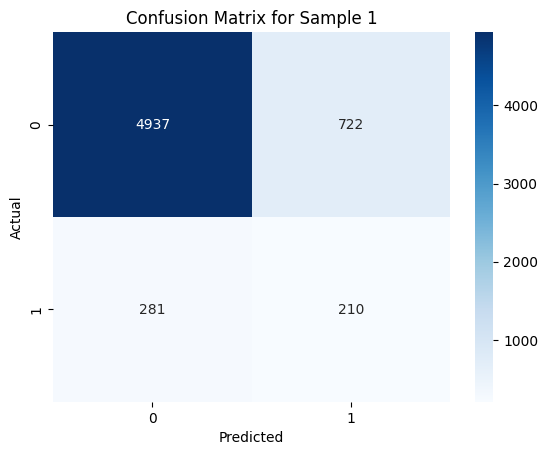

Classification Report for Sample 1:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      5659
           1       0.23      0.43      0.30       491

    accuracy                           0.84      6150
   macro avg       0.59      0.65      0.60      6150
weighted avg       0.89      0.84      0.86      6150

F1 Score (Positive Class) for Sample 1: 0.2951510892480675


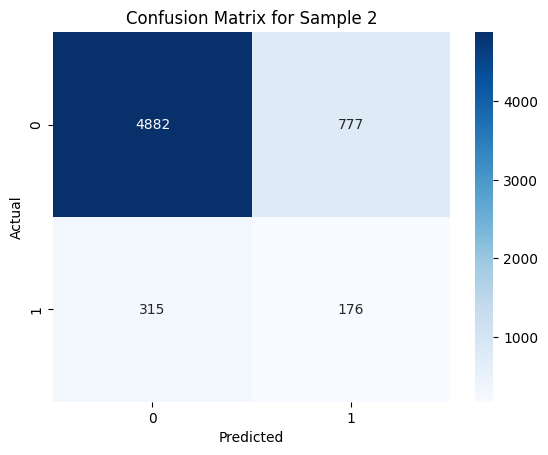

Classification Report for Sample 2:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5659
           1       0.18      0.36      0.24       491

    accuracy                           0.82      6150
   macro avg       0.56      0.61      0.57      6150
weighted avg       0.88      0.82      0.85      6150

F1 Score (Positive Class) for Sample 2: 0.24376731301939059


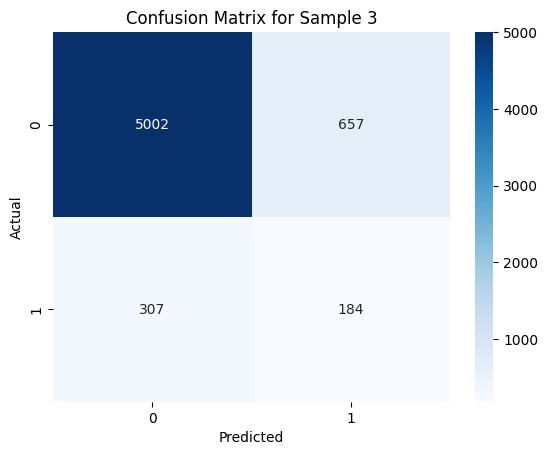

Classification Report for Sample 3:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5659
           1       0.22      0.37      0.28       491

    accuracy                           0.84      6150
   macro avg       0.58      0.63      0.59      6150
weighted avg       0.88      0.84      0.86      6150

F1 Score (Positive Class) for Sample 3: 0.27627627627627627


In [145]:
from sklearn.metrics import f1_score

feature_importances = pd.DataFrame(columns=['Feature'])

for i in range(num_samples_to_create):
    rf_classifiers[i].fit(X_train_samples_list[i], y_train_samples_list[i])
    y_pred = rf_classifiers[i].predict(X_test_samples_list[i])

    conf_matrix = confusion_matrix(y_test_samples_list[i], y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Sample {i + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"Classification Report for Sample {i + 1}:\n{classification_report(y_test_samples_list[i], y_pred)}")

    f1 = f1_score(y_test_samples_list[i], y_pred, pos_label=1)
    print(f"F1 Score (Positive Class) for Sample {i + 1}: {f1}")

    feature_importances[f'Sample_{i + 1}'] = rf_classifiers[i].feature_importances_

feature_importances['Feature'] = X_train_samples_list[0].columns



As we got very poor F1-scores: around 0.3, I will have to do modifications, as the current models do not capture important patterns.

Handling the missing values in the dataset.

In [146]:
training_data.isna().sum()[training_data.isna().sum()>0]

,0
bureau_earlier_credits_count,44020
bureau_pct_Active,44020
bureau_pct_Closed,44020
bureau_pct_Sold,44020
bureau_pct_other,44020
...,...
NAME_PORTFOLIO_POS,16455
NAME_PRODUCT_TYPE_x-sell,16455
NAME_YIELD_GROUP_low_action,16455
NAME_YIELD_GROUP_low_normal,16455


Downcast numeric types to save memory.

In [147]:
training_data = training_data.apply(pd.to_numeric, downcast='float')
training_data = training_data.apply(pd.to_numeric, downcast='integer')

training_data['EMERGENCYSTATE_MODE'] = training_data['EMERGENCYSTATE_MODE'].apply(lambda x: 1 if x is True else (0 if x is False else x))

training_data.dtypes.unique()


array([dtype('int8'), dtype('int16'), dtype('float32'), dtype('int32'),
       dtype('int64'), Int8Dtype(), Int16Dtype(), Int32Dtype()],
      dtype=object)

In [148]:
testing_data = testing_data.apply(pd.to_numeric, downcast='float')
testing_data = testing_data.apply(pd.to_numeric, downcast='integer')

testing_data['EMERGENCYSTATE_MODE'] = testing_data['EMERGENCYSTATE_MODE'].apply(lambda x: 1 if x is True else (0 if x is False else x))

Clean column names from confusing characters.

In [149]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[\"\'{}\[\]:, ]', '', regex=True)
    return df

training_data = clean_column_names(training_data)
testing_data = clean_column_names(testing_data)

Impute the missing values and indicate them with a flag for predictive power.

In [150]:
from sklearn.impute import SimpleImputer

cols_with_missing = training_data.columns[training_data.isnull().any()]

missing_indicators = pd.concat(
    [training_data[col].isnull().astype('int8').rename(f'{col}_was_missing') for col in cols_with_missing],
    axis=1
)

training_data = pd.concat([training_data, missing_indicators], axis=1)

imputer = SimpleImputer(strategy='median')
training_data[cols_with_missing] = imputer.fit_transform(training_data[cols_with_missing])

missing_indicators_test = pd.concat(
    [testing_data[col].isnull().astype('int8').rename(f'{col}_was_missing') for col in cols_with_missing],
    axis=1
)
testing_data = pd.concat([testing_data, missing_indicators_test], axis=1)

testing_data[cols_with_missing] = imputer.transform(testing_data[cols_with_missing])


Create baseline model using the imputed dataset.

In [151]:
training_data['TARGET']

,TARGET
0,0
1,0
2,0
3,0
4,1
...,...
307506,1
307507,0
307508,0
307509,0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     56538
           1       0.23      0.43      0.30      4965

    accuracy                           0.84     61503
   macro avg       0.59      0.65      0.60     61503
weighted avg       0.89      0.84      0.86     61503

F1-score (macro): 0.6043836565651519
F1-score (pos class): 0.30070663961379696


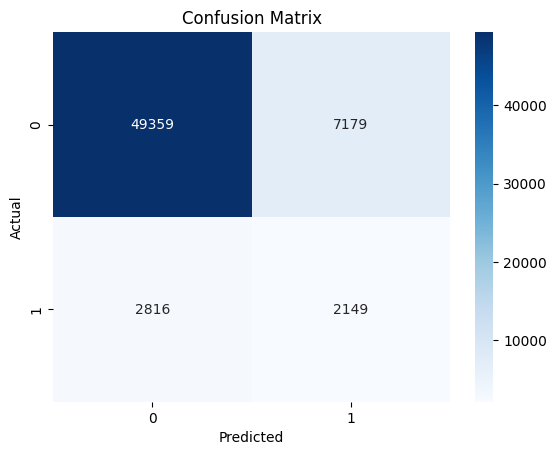

In [152]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

X = training_data.drop(columns=['TARGET', 'SK_ID_CURR'])
y = training_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1-score (pos class):", f1_score(y_test, y_pred, pos_label=1))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The performance is still really poor after imputing the missing values.

I will try SMOTE to compensate for the imbalance in the target.

In [153]:
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [154]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [155]:
def tune_classifier(model, X_train, y_train, param_grid, cv_splits=3, scoring='f1'):
    """
    Tunes a classifier model using GridSearchCV with Stratified K-Fold.

    Args:
        model (estimator): The classifier model to tune (e.g., LogisticRegression(), LGBMClassifier()).
        X_train (array-like): Training feature data.
        y_train (array-like): Training target data.
        param_grid (dict): Dictionary of hyperparameters and their values to search.
        cv_splits (int): Number of cross-validation folds.
        scoring (str): Scoring metric to optimize (e.g., 'accuracy', 'f1', 'roc_auc').

    Returns:
        GridSearchCV: Fitted GridSearchCV object containing the results of the search.
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=1,
        n_jobs=-1
    )

    print(f"Starting GridSearchCV for {type(model).__name__} with scoring='{scoring}' and {cv_splits}-fold cross-validation...")
    grid_search.fit(X_train, y_train)
    print("GridSearchCV finished.")

    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Best {scoring} (Cross-Validation): {grid_search.best_score_:.4f}")

    return grid_search

Subsample from the training set, so we can deetrmine faster which models show potential for actual training and CV.

In [156]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_res, y_res, test_size=0.85, stratify=y_res, random_state=42)

Create a tracker table for the results of the training.

In [157]:
sample_train_results = pd.DataFrame(columns = [['model', 'F1-score']])

Save the trained models for later loading.

In [158]:
model_save_path = '/content/drive/My Drive/Turing/ML Capstone project/trained_models'

os.makedirs(model_save_path, exist_ok=True)

In [159]:
from sklearn.linear_model import LogisticRegression

if not os.path.exists(os.path.join(model_save_path, 'logreg_model.pkl')):
    logreg_model = LogisticRegression(max_iter=1000, solver='saga')
    logreg_model.fit(X_train_sample, y_train_sample)
    joblib.dump(logreg_model, model_save_path + '/logreg_model.pkl')
else:
    logreg_model = joblib.load(model_save_path + '/logreg_model.pkl')

In [160]:
from sklearn.metrics import f1_score

log_preds = logreg_model.predict(X_test_sample)

f1_score(y_test_sample, log_preds, pos_label=1)

0.5957122484803259

In [161]:
def add_model_result(df, model_name, y_true, y_pred, pos_label=1):
    f1 = f1_score(y_true, y_pred, pos_label=pos_label)
    new_row = pd.DataFrame({'model': [model_name], 'F1-score': [round(f1, 4)]})
    return pd.concat([df, new_row], ignore_index=True)

In [162]:
new_row = pd.DataFrame({'model': 'Logistic Regression', 'F1-score': f1_score(y_test_sample, log_preds, pos_label=1)}, index=[0])
sample_train_results = pd.concat([sample_train_results, new_row], ignore_index=True)

In [163]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [164]:
if not os.path.exists(os.path.join(model_save_path, 'balanced_forest.pkl')):
    balanced_forest = BalancedRandomForestClassifier()
    balanced_forest.fit(X_train_sample, y_train_sample)
    joblib.dump(balanced_forest, model_save_path + '/balanced_forest.pkl')
else:
    balanced_forest = joblib.load(model_save_path + '/balanced_forest.pkl')

In [165]:
sample_train_results = add_model_result(sample_train_results, 'Balanced Random Forest', y_test_sample, balanced_forest.predict(X_test_sample))

In [166]:
xgb_model_path = os.path.join(model_save_path, 'xgboost.pkl')

if not os.path.exists(xgb_model_path):
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
    xgb.fit(X_train_sample, y_train_sample)
    joblib.dump(xgb, xgb_model_path)
else:
    xgb = joblib.load(xgb_model_path)

In [167]:
sample_train_results = add_model_result(sample_train_results, 'XGBoost', y_test_sample, xgb.predict(X_test_sample))

In [168]:
lgbm_model_path = os.path.join(model_save_path, 'lgbm.pkl')

if not os.path.exists(lgbm_model_path):
    lgbm = LGBMClassifier(
        objective='binary',
        metric='f1',
        random_state=42,
        n_jobs=-1
    )
    lgbm.fit(
        X_train_sample, y_train_sample,
        eval_set=[(X_test_sample, y_test_sample)],
        eval_metric='f1',
    )
    joblib.dump(lgbm, lgbm_model_path)
else:
    lgbm = joblib.load(lgbm_model_path)

[LightGBM] [Info] Number of positive: 33922, number of negative: 33922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54077
[LightGBM] [Info] Number of data points in the train set: 67844, number of used features: 487
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [169]:
sample_train_results = add_model_result(sample_train_results, 'LGBM', y_test_sample, lgbm.predict(X_test_sample))

In [170]:
knn_model_path = os.path.join(model_save_path, 'knn.pkl')

if not os.path.exists(knn_model_path):
    knn = KNeighborsClassifier(n_jobs=-1)
    knn.fit(X_train_sample, y_train_sample)
    joblib.dump(knn, knn_model_path)
else:
    knn = joblib.load(knn_model_path)

In [171]:
sample_train_results = add_model_result(sample_train_results, 'K-Nearest Neighbors', y_test_sample, knn.predict(X_test_sample))

Select the best models based on the F1-score for further training on the complete dataset including cross validation and tuning.

In [172]:
sample_train_results.sort_values(by='F1-score', ascending=False)

,"(model,)","(F1-score,)",model,F1-score
3,NaN,NaN,LGBM,0.953100
2,NaN,NaN,XGBoost,0.952100
1,NaN,NaN,Balanced Random Forest,0.945800
4,NaN,NaN,K-Nearest Neighbors,0.749900
0,NaN,NaN,Logistic Regression,0.595712


The best performing models were:
- Balanced Random Forest
- XGBoost
- LGBM

I will use these type of models for Hyperparameter Tuning using CV.

In [173]:
models = {
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='f1', random_state=42, n_jobs=-1),
    'LGBM': LGBMClassifier(objective='binary', metric='f1', random_state=42, n_jobs=-1),
}

param_grids = {
    'Balanced Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LGBM': {
        'n_estimators': [100, 200],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 1.0]
    },
}



In [177]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import optuna
from sklearn.metrics import (
    f1_score, precision_score, recall_score, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle

def tune_and_evaluate_models(models, param_grids, X_train, y_train, X_test, y_test, model_save_path, scoring='f1', n_trials=30):
    best_models = {}
    results = []

    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    for name, base_model in models.items():
        file_name = f'{name.replace(" ", "_").lower()}_model_optuned.pkl'
        full_path = os.path.join(model_save_path, file_name)

        if os.path.exists(full_path):
            print(f"📦 Loading {name} from saved model at {full_path}")
            with open(full_path, 'rb') as f:
                best_model = pickle.load(f)
        else:
            print(f"🔍 Tuning {name}...")

            if name == 'Gradient Boosting':
                grid = RandomizedSearchCV(
                base_model,
                param_distributions=param_grids[name],
                n_iter=10,
                scoring=scoring,
                cv=3,
                n_jobs=-1,
                random_state=42
            )
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                print(f"✅ GridSearch best params for {name}: {grid.best_params_}")

            else:
                def objective(trial):
                    params = {
                        key: trial.suggest_categorical(key, values)
                        for key, values in param_grids[name].items()
                    }
                    model = base_model.__class__(**params)

                    model.set_params(random_state=42)
                    if hasattr(model, 'n_jobs'):
                        model.set_params(n_jobs=-1)

                    if name == 'LGBM':
                        model.set_params(objective='binary', metric='f1')
                        model.fit(X_train_sub, y_train_sub,
                                  eval_set=[(X_val, y_val)])
                        preds = model.predict(X_val)
                    else:
                        model.fit(X_train_sub, y_train_sub)
                        preds = model.predict(X_val)

                    return f1_score(y_val, preds)

                study = optuna.create_study(direction='maximize')
                study.optimize(objective, n_trials=n_trials)

                best_params = study.best_params
                print(f"✅ Optuna best params for {name}: {best_params}")

                best_model = base_model.__class__(**best_params)
                best_model.set_params(random_state=42)
                if hasattr(best_model, 'n_jobs'):
                    best_model.set_params(n_jobs=-1)

                if name == 'LGBM':
                    best_model.set_params(objective='binary', metric='f1')
                    best_model.fit(X_train_sub, y_train_sub,
                                   eval_set=[(X_val, y_val)],
                                   )
                else:
                    best_model.fit(X_train, y_train)

            with open(full_path, 'wb') as f:
                pickle.dump(best_model, f)
            print(f"💾 Saved {name} model to {full_path}")

        best_models[name] = best_model
        y_pred = best_model.predict(X_test)
        y_scores = best_model.predict_proba(X_test)[:, 1]

        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        results.append({
            'Model': name,
            'F1 Score': round(f1, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4)
        })

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        print()

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.title(f'{name} - ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print()

        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall_vals, precision_vals)

        plt.figure(figsize=(5, 4))
        plt.plot(recall_vals, precision_vals, label=f'AUC = {pr_auc:.4f}')
        plt.title(f'{name} - Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print()

    results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
    return best_models, results_df


Splitting the SMOTE-compensated dataset to get training and testing set.

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

📦 Loading Balanced Random Forest from saved model at /content/drive/My Drive/Turing/ML Capstone project/trained_models/balanced_random_forest_model_optuned.pkl


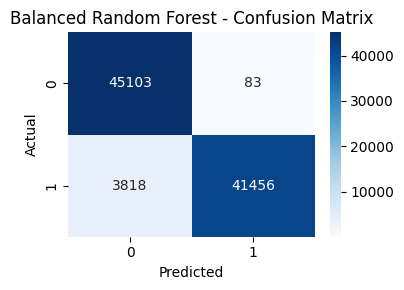

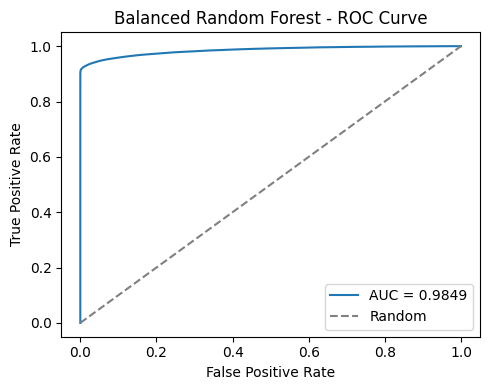

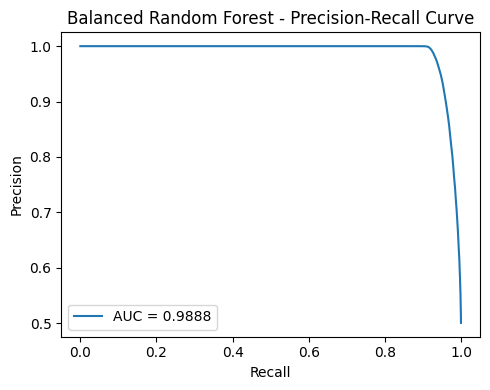


📦 Loading XGBoost from saved model at /content/drive/My Drive/Turing/ML Capstone project/trained_models/xgboost_model_optuned.pkl


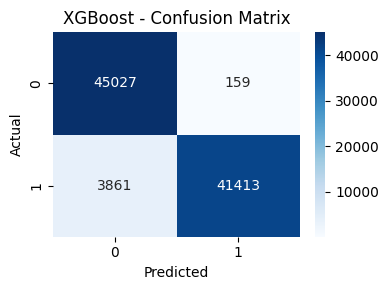

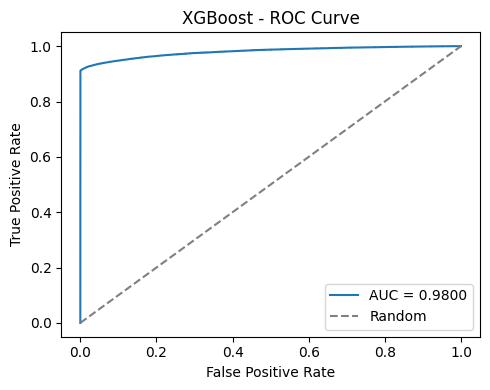

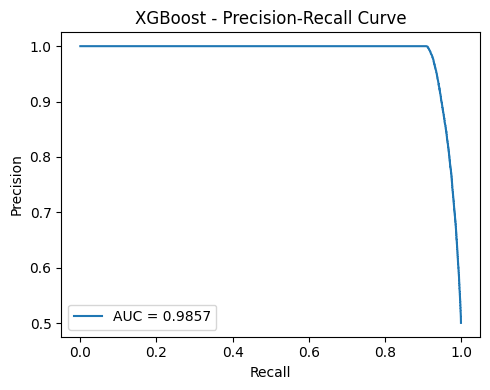

[I 2025-05-17 14:10:49,455] A new study created in memory with name: no-name-9de28ad7-d680-471c-905a-bae590760efa



🔍 Tuning LGBM...
[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.321990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:11:07,330] Trial 0 finished with value: 0.9529877040339397 and parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.2, 'num_leaves': 31, 'subsample': 1.0}. Best is trial 0 with value: 0.9529877040339397.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.673120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:11:24,097] Trial 1 finished with value: 0.9530066270862384 and parameters: {'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.2, 'num_leaves': 100, 'subsample': 0.8}. Best is trial 1 with value: 0.9530066270862384.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.686423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:11:45,173] Trial 2 finished with value: 0.9273149586495643 and parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 100, 'subsample': 1.0}. Best is trial 1 with value: 0.9530066270862384.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:12:00,408] Trial 3 finished with value: 0.9533372711163615 and parameters: {'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.2, 'num_leaves': 31, 'subsample': 0.8}. Best is trial 3 with value: 0.9533372711163615.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.920830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:12:15,696] Trial 4 finished with value: 0.9529926839103635 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'num_leaves': 31, 'subsample': 0.8}. Best is trial 3 with value: 0.9533372711163615.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.735084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:12:53,768] Trial 5 finished with value: 0.943263964950712 and parameters: {'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 100, 'subsample': 1.0}. Best is trial 3 with value: 0.9533372711163615.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.709791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:13:11,393] Trial 6 finished with value: 0.953126123664188 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'num_leaves': 31, 'subsample': 1.0}. Best is trial 3 with value: 0.9533372711163615.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.706754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:13:25,510] Trial 7 finished with value: 0.9533039647577093 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 31, 'subsample': 0.8}. Best is trial 3 with value: 0.9533372711163615.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.738012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:13:39,343] Trial 8 finished with value: 0.9532505056342098 and parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'num_leaves': 31, 'subsample': 1.0}. Best is trial 3 with value: 0.9533372711163615.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:14:02,294] Trial 9 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.720779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:14:25,802] Trial 10 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.702671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:14:47,735] Trial 11 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.708505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:15:09,636] Trial 12 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.351169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:15:32,636] Trial 13 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.721594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:15:56,183] Trial 14 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.709777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:16:18,221] Trial 15 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:16:47,146] Trial 16 finished with value: 0.9412556119389889 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.719259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:17:09,179] Trial 17 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.718072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:17:32,848] Trial 18 finished with value: 0.9536549855126782 and parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 0.8}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.735441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:17:55,380] Trial 19 finished with value: 0.9535832144452611 and parameters: {'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:18:23,724] Trial 20 finished with value: 0.9412556119389889 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.693772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:18:45,870] Trial 21 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.703019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:19:09,420] Trial 22 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.707325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:19:31,245] Trial 23 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.735381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:19:53,192] Trial 24 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:20:20,556] Trial 25 finished with value: 0.9536263609654934 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 100, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.714653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:20:42,793] Trial 26 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 0.8}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.714816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:21:06,085] Trial 27 finished with value: 0.9537175792507204 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.723374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:21:35,022] Trial 28 finished with value: 0.9404788051833955 and parameters: {'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 50, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.726166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484


[I 2025-05-17 14:22:03,476] Trial 29 finished with value: 0.9536360886661194 and parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.1, 'num_leaves': 100, 'subsample': 1.0}. Best is trial 9 with value: 0.9537175792507204.


✅ Optuna best params for LGBM: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'subsample': 1.0}
[LightGBM] [Info] Number of positive: 144699, number of negative: 144769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55279
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499879 -> initscore=-0.000484
[LightGBM] [Info] Start training from score -0.000484
💾 Saved LGBM model to /content/drive/My Drive/Turing/ML Capstone project/trained_models/lgbm_model_optuned.pkl


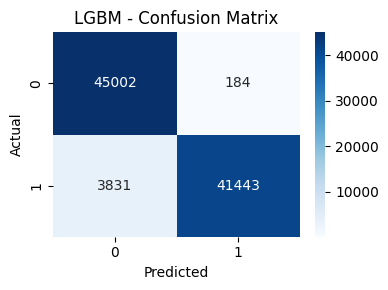

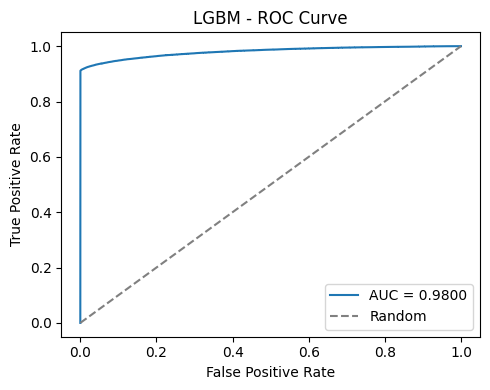

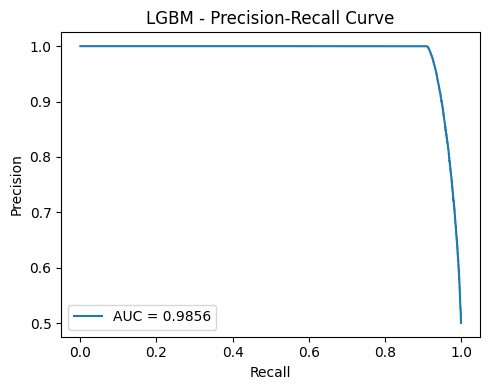

In [178]:
best_models, results_df = tune_and_evaluate_models(models, param_grids, X_train, y_train, X_test, y_test, model_save_path)

[LightGBM] [Info] Number of positive: 180874, number of negative: 180962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.903250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55267
[LightGBM] [Info] Number of data points in the train set: 361836, number of used features: 496
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499878 -> initscore=-0.000486
[LightGBM] [Info] Start training from score -0.000486
Saved voting_ensemble model to /content/drive/My Drive/Turing/ML Capstone project/trained_models/voting_ensemble.pkl

Voting Classifier Performance:
Accuracy: 0.9563
F1 Score (Positive Class): 0.9545

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     45186
           1       1.00      0.91      0.95     45274

    accuracy                           0.96     90460
   macro avg       0.96      0.96    

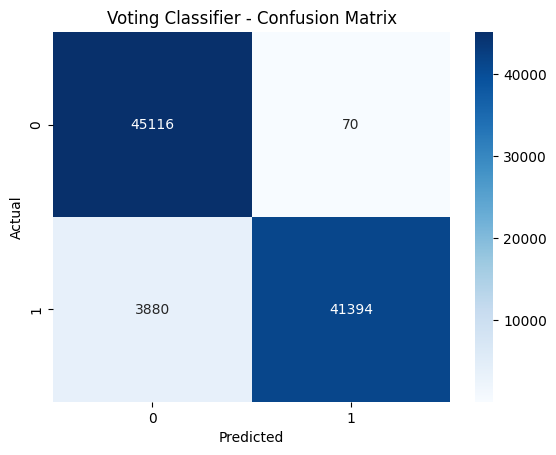

In [179]:
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

estimators = [(name, model) for name, model in best_models.items()]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')

voting_clf.fit(X_train, y_train)

file_name = f'voting_ensemble.pkl'
full_path = os.path.join(model_save_path, file_name)
with open(full_path, 'wb') as f:
  pickle.dump(voting_clf, f)
print(f'Saved voting_ensemble model to {full_path}')


y_pred_voting = voting_clf.predict(X_test)

voting_accuracy = accuracy_score(y_test, y_pred_voting)
voting_f1 = f1_score(y_test, y_pred_voting, pos_label=1)

print("\nVoting Classifier Performance:")
print(f"Accuracy: {voting_accuracy:.4f}")
print(f"F1 Score (Positive Class): {voting_f1:.4f}")

print("\nClassification Report for Voting Classifier:")
print(classification_report(y_test, y_pred_voting))

print("\nConfusion Matrix for Voting Classifier:")
cm_voting = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Voting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [180]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kataherndi","key":"fbcc30c1c4e33978061e301299c38a95"}'}

In [183]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [184]:
test_id = testing_data['SK_ID_CURR']

In [185]:
testing_data.columns

Index(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       ...
       'NAME_PAYMENT_TYPE_Non-cashfromyouraccount_was_missing',
       'NAME_CLIENT_TYPE_Refreshed_was_missing',
       'NAME_CLIENT_TYPE_Repeater_was_missing',
       'NAME_PORTFOLIO_Cars_was_missing', 'NAME_PORTFOLIO_Cash_was_missing',
       'NAME_PORTFOLIO_POS_was_missing',
       'NAME_PRODUCT_TYPE_x-sell_was_missing',
       'NAME_YIELD_GROUP_low_action_was_missing',
       'NAME_YIELD_GROUP_low_normal_was_missing',
       'NAME_YIELD_GROUP_middle_was_missing'],
      dtype='object', length=510)

In [186]:
test_records = testing_data.loc[testing_data['SK_ID_CURR'].isin(test_id)].drop(columns = ['SK_ID_CURR'])

In [187]:
test_results = voting_clf.predict(testing_data.drop(columns=['SK_ID_CURR']))

In [188]:
test_frame = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_results})

In [190]:
test_frame.to_csv('submission.csv', index=False)

In [191]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "submission"

100% 428k/428k [00:00<00:00, 2.39MB/s]
Successfully submitted to Home Credit Default Risk